In [1]:
import nltk
from nltk.corpus import brown

In [2]:
nltk.download("brown")
nltk.download("universal_tagset")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
corpus = brown.tagged_sents(tagset="universal")

In [4]:
corpus

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [5]:
len(corpus)

57340

In [6]:
inputs = []
targets = []

for sentence_tag_pairs in corpus:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  inputs.append(tokens)
  targets.append(target)

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional, LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [32]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(inputs, targets, test_size=0.33)

In [33]:
MAX_VOCAB_SIZE = None
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=False,
    oov_token="UNK"
)

word_tokenizer.fit_on_texts(Xtrain)
train_inputs_int = word_tokenizer.texts_to_sequences(Xtrain)
test_inputs_int = word_tokenizer.texts_to_sequences(Xtest)

In [45]:
word2idx = word_tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens.")

Found 46630 unique tokens.


In [34]:
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [35]:
Ytrain_ = set(flatten(Ytrain))
Ytrain_

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [36]:
Ytest_ = set(flatten(Ytest))
Ytest_

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [37]:
Ytrain_ == Ytest_

True

In [38]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Ytrain)
Ytrain = tag_tokenizer.texts_to_sequences(Ytrain)
Ytest = tag_tokenizer.texts_to_sequences(Ytest)

In [18]:
Ytrain_unpadded = Ytrain
Ytest_unpadded = Ytest

In [39]:
T = max(max(len(sent) for sent in Xtrain), max(len(sent) for sent in Xtest))
T

180

In [40]:
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print(f"Shape of data train tensor: {train_inputs_int.shape}")

Shape of data train tensor: (38417, 180)


In [41]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print(f"Shape of data test tensor: {test_inputs_int.shape}")

Shape of data test tensor: (18923, 180)


In [42]:
Ytrain = pad_sequences(Ytrain, maxlen=T)
print(f"Shape of train targets tensor: {Ytrain.shape}")

Shape of train targets tensor: (38417, 180)


In [43]:
Ytest = pad_sequences(Ytest, maxlen=T)
print(f"Shape of test targets tensor: {Ytest.shape}")

Shape of test targets tensor: (18923, 180)


In [44]:
K = len(tag_tokenizer.word_index) + 1
K

13

In [46]:
D = 32

i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [54]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

ft = model.fit(
    train_inputs_int, Ytrain,
    epochs=5,
    validation_data=(test_inputs_int, Ytest)
)

Epoch 1/5
1201/1201 [==============================] - 395s 321ms/step - loss: 0.0405 - accuracy: 0.8976 - val_loss: 0.0126 - val_accuracy: 0.9657
Epoch 2/5
1201/1201 [==============================] - 361s 301ms/step - loss: 0.0081 - accuracy: 0.9776 - val_loss: 0.0101 - val_accuracy: 0.9714
Epoch 3/5
1201/1201 [==============================] - 419s 349ms/step - loss: 0.0050 - accuracy: 0.9858 - val_loss: 0.0098 - val_accuracy: 0.9728
Epoch 4/5
1201/1201 [==============================] - 368s 306ms/step - loss: 0.0038 - accuracy: 0.9894 - val_loss: 0.0101 - val_accuracy: 0.9732
Epoch 5/5
1201/1201 [==============================] - 302s 251ms/step - loss: 0.0029 - accuracy: 0.9917 - val_loss: 0.0107 - val_accuracy: 0.9726


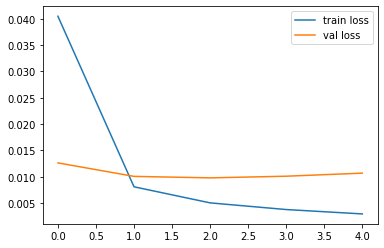

In [56]:
plt.plot(ft.history["loss"], label="train loss")
plt.plot(ft.history["val_loss"], label="val loss")
plt.legend();

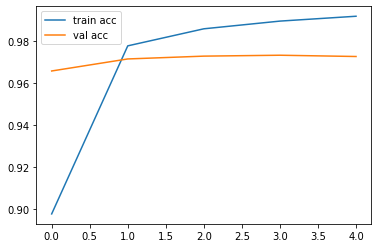

In [57]:
plt.plot(ft.history["accuracy"], label="train acc")
plt.plot(ft.history["val_accuracy"], label="val acc")
plt.legend();

In [58]:
train_lengths = []
for sentence in Xtrain:
  train_lengths.append(len(sentence))



In [59]:
test_lengths = []
for sentence in Xtest:
  test_lengths.append(len(sentence))

In [60]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs,length in zip(train_probs, train_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(Ytrain_unpadded)

1201/1201 [==============================] - 59s 46ms/step


In [61]:
test_probs = model.predict(test_inputs_int)
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(Ytest_unpadded)

592/592 [==============================] - 34s 58ms/step


In [62]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc: ", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc: ", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1: ", f1_score(flat_train_targets, flat_train_predictions, average="macro"))
print("Test f1: ", f1_score(flat_test_targets, flat_test_predictions, average="macro"))

ValueError: ignored

In [ ]:
from collections import Counter

def most_common(lst):
  data = Counter(lst)
  return data.most_common(1)[0][0]

In [ ]:
token2tags = {k: [] for k,v in word2idx.items()}

In [ ]:
del token2tags["UNK"]

In [ ]:
for tokens,tags in zip(Xtrain, Ytrain):
  for token, tag in zip(tokens, tags):
    if token in token2tags:
      token2tags[token].append(tags)

token2tag = {k:most_common(v) for k, v in token2tags.items()}

In [ ]:
train_predictions = []
for sentence in Xtrain:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(Ytrain)

In [ ]:
test_predictions = []
for sentence in Xtrain:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, "INCORRECT")
    predictions.append(predicted_tag)
  train_predictions.append(predictions)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(Ytrain)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc: ", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc: ", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1: ", f1_score(flat_train_targets, flat_train_predictions, average="macro"))
print("Test f1: ", f1_score(flat_test_targets, flat_test_predictions, average="macro"))